In [1]:
# first we load the required libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from stop_words import get_stop_words
from scipy.sparse import coo_matrix

# for ggplot style plots
plt.style.use("ggplot")

In [2]:
# data from: http://deepyeti.ucsd.edu/jianmo/amazon/
# Paper:
# Justifying recommendations using distantly-labeled reviews and fined-grained aspects
# Jianmo Ni, Jiacheng Li, Julian McAuley
# Empirical Methods in Natural Language Processing (EMNLP), 2019

# to store the stars and reviews
stars = []
revs = []
# Opening JSON file
with open('/home/michal/jupyterlab/Appliances.json') as file:
    # Iterating through the json list
    for json_text in list(file):
        # getting a dictionary from json text
        ls = eval(json_text.replace("false","False").replace("true","True"))
        
        # using the dictionary to get the information needed
        stars.append(ls["overall"])
        try:
            revs.append(ls["reviewText"])
        except KeyError:
            revs.append("")

# creating the dataframe
resenas_amazon = pd.DataFrame(list(zip(stars,revs)),columns = ['estrellas','comentario'])

In [3]:
# check for duplicates
resenas_amazon[resenas_amazon.duplicated()]
''' the duplicates exist for short reviews or people write the same things sometimes (especially for good reviews) '''

' the duplicates exist for short reviews or people write the same things sometimes (especially for good reviews) '

In [4]:
# information about the dataframe
resenas_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602777 entries, 0 to 602776
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   estrellas   602777 non-null  float64
 1   comentario  602777 non-null  object 
dtypes: float64(1), object(1)
memory usage: 9.2+ MB


In [5]:
# we change the type to be more economics
resenas_amazon['estrellas'] = resenas_amazon['estrellas'].astype(np.ushort)

In [6]:
# how many reviews of what values are there
resenas_amazon.groupby("estrellas").count()

,comentario
estrellas,
1,59627
2,20734
3,30652
4,75476
5,416288


In [7]:
# we work with a copy
resenas_amazon_mod = resenas_amazon.copy()

In [8]:
# new column with review values reduced to good (above 3) - value 1 or bad - value 0 (below or equal to 3): 
resenas_amazon_mod['resena'] = pd.cut(resenas_amazon['estrellas'], bins = [0,3.5,5.5], labels = [0,1])

In [9]:
# text clean up and a new column
resenas_amazon_mod['palabras'] = [x.lower().replace(',','').replace('.','').replace('(','').replace(')','') for x in resenas_amazon_mod['comentario']]

In [10]:
# we remove old reviews
del resenas_amazon_mod['comentario']

In [11]:
# we display the first lines of our dataframe
resenas_amazon_mod.head()

,estrellas,resena,palabras
0,5,1,not one thing in this book seemed an obvious o...
1,5,1,i have enjoyed dr alan gregerman's weekly blog...
2,5,1,alan gregerman believes that innovation comes ...
3,5,1,alan gregerman is a smart funny entertaining w...
4,5,1,as i began to read this book i was again remin...


In [12]:
# let's get the stop words
stop_words = get_stop_words('en')

In [13]:
# we import nltk
import nltk

In [14]:
# to get the stemmer
from nltk.stem.snowball import SnowballStemmer

In [15]:
# we transform the text into text of stems and remove stop words
englishStemmer=SnowballStemmer("english")

y = []
for x in resenas_amazon_mod['palabras']:
    x_new = ' '.join([englishStemmer.stem(word) for word in x.split() if word.isalpha() and not word in stop_words])
    y.append(x_new)

resenas_amazon_mod['palabras'] = y

del y

In [16]:
# function that produces a dictionary of words and their count
def dict_bow(text):
    lista = text.split()
    return {x: lista.count(x) for x in lista}

In [18]:
# function that produces a dictionary of bigrams and their count
def dict_bow_bi(text):
    bigrams_a = nltk.bigrams(text.split())
    lista = list(bigrams_a)
    return {x: lista.count(x) for x in lista}

In [19]:
# function that produces a dictionary of trigrams and their count
def dict_bow_tri(text):
    trigrams_a = nltk.trigrams(text.split())
    lista = list(trigrams_a)
    return {x: lista.count(x) for x in lista}

In [20]:
# this function generates a sparse-matrix for words, bigrams and trigrams
# text_list is a list of texts
# n controls what degree of n-grams is included
# num_mas_fr, num_mas_fr_bi, num_mas_fr_tri are parameters of cuts on number of n-grams incluided
def text_list_into_S(text_list, n = 1, num_mas_fr = 3000, num_mas_fr_bi = None, num_mas_fr_tri = None) :
# initialisation of arguments
    if num_mas_fr_bi is None: num_mas_fr_bi = num_mas_fr
    if num_mas_fr_tri is None: num_mas_fr_tri = num_mas_fr
        
# first we construct dictionaries that contain all the words/n-grams and their frequencies
    big_dict = {}
    big_dict_bi = {}
    big_dict_tri = {}
    for x in text_list:
        
        words_raw = x.split()

        if n >= 2:
            bigrams_raw = list(nltk.bigrams(x.split()))
            
            for bi_el in bigrams_raw:
                try:
                    big_dict_bi[bi_el] += 1
                except KeyError:
                    big_dict_bi[bi_el] = 1
            
            if n == 3:
                trigrams_raw = list(nltk.trigrams(x.split()))
                
                for tri_el in trigrams_raw:
                    try:
                        big_dict_tri[tri_el] += 1
                    except KeyError:
                        big_dict_tri[tri_el] = 1
          
        for el in words_raw:
            try:
                big_dict[el] += 1
            except KeyError:
                big_dict[el] = 1
    
    del words_raw
    if n >= 2: del bigrams_raw
    if n == 3: del trigrams_raw
    
    print('Number of unique words:',len(set(big_dict.keys())))
    print('Included text (%):',100*sum(sorted(big_dict.values(), reverse = True)[:num_mas_fr])/sum(sorted(big_dict.values(), reverse = True)),'%')

# here we order the words according to their frequency and keep only the first num_mas_fr most frequent words
    un_word_list_red = sorted(big_dict, key = big_dict.get, reverse = True)[:num_mas_fr]
    del big_dict

# in case of n == 2 o n == 3, we filter bigrams or/and trigrams that contain only most frequent words
    if n >= 2:
# in addition, we apply cuts on number of bigrams and trigrams
        bigrams_all = sorted(big_dict_bi, key = big_dict_bi.get, reverse = True)[:num_mas_fr_bi]
        bigrams = [bi for bi in bigrams_all if bi[0] in un_word_list_red and bi[1] in un_word_list_red]
        del big_dict_bi

        if n == 3:
            trigrams_all = sorted(big_dict_tri, key = big_dict_tri.get, reverse = True)[:num_mas_fr_tri]
            trigrams = [tri for tri in trigrams_all if tri[0] in un_word_list_red and tri[1] in un_word_list_red and
                       tri[2] in un_word_list_red]
            del big_dict_tri
    
# dictionaries with information about columns
    dict_big = {k: v for v, k in enumerate(un_word_list_red)}
    if n >= 2:
        dict_big_bi = {k: v for v, k in enumerate(bigrams)}
        if n == 3:
            dict_big_tri = {k: v for v, k in enumerate(trigrams)}

# row_shift1 and row_shift2 to calculate indices of bigrams and/or trigrams
    row_shift1 = len(un_word_list_red)
    if n == 3: row_shift2 = len(bigrams) + row_shift1

# n_coo and n_col positional variables for rows
    n_coo = 0 # number of the row
    n_col = 0 # number of the row tracker
# values (data), indices and rows of the sparse matrix
    data = []
    ind = []
    row = []
# list row_zero stores the eliminated rows
    row_zero = []

# loop over the texts
    for com in text_list:

# here we get dictionaries with conts of words/n-grams in text com
        dicc = dict_bow(com)
        if n >= 2: 
            dicc_bi = dict_bow_bi(com)

        if n == 3: 
            dicc_tri = dict_bow_tri(com)
            
# auxiliary values (data), indices and rows for words, bigrams and trigrams
        ind_a = []
        row_a = []
        data_a = []

        ind_b = []
        row_b = []
        data_b = []
        
        ind_t = []
        row_t = []
        data_t = []

# loop over unique words in text and extraction of the index, value and row
        for word in dicc.keys():
            try:
                ind_a.append(dict_big[word])

                data_a.append(dicc[word])

                row_a.append(n_coo)
            except KeyError:
                pass

# oop over unique bi/tri-grams in text and extraction of the index, value and row
        if n >= 2:
            for bigr in dicc_bi.keys():
                try:
                    ind_b.append(dict_big_bi[bigr] + row_shift1)

                    data_b.append(dicc_bi[bigr])

                    row_b.append(n_coo)
                except KeyError:
                    pass
            if n == 3:
                for trigr in dicc_tri.keys():
                    try:
                        ind_t.append(dict_big_tri[word] + row_shift2)
        
                        data_t.append(dicc_tri[word])
            
                        row_t.append(n_coo)
                    except KeyError:
                        pass

# if there are some wotds in the text, we construct final data, index and rows; and increase the nunmber of the row
        if sum(data_a) != 0:
            n_coo += 1
            data += data_a + data_b + data_t
            ind += ind_a + ind_b + ind_t
            row += row_a + row_b + row_t
        else:
# if there are no words in the text, we keep the number of the column in row_zero
            row_zero.append(n_col)
# we increase the value of the row tracker
        n_col += 1

# how many rows did we remove
    print('Numero de filas perdidas:',len(row_zero))

# dimensions of the matrix
    m_rows = text_list.shape[0]-len(row_zero)
    m_cols = row_shift1
    if n == 2: m_cols = row_shift1 + len(bigrams)
    if n == 3: m_cols = row_shift2 + len(trigrams)

    print('Numero de filas:',m_rows,'Numero de columnas:',m_cols)

# constrction of the sparse matrix
    S_m = coo_matrix((data, (row, ind)), shape = (m_rows, m_cols), dtype=np.ushort)

# results: sparse matrix and the removed rows
    return (S_m,row_zero)

In [21]:
# we execte the function text_list_into_S to obtain the sparse matrix and list of lost rows
# to test the model it is possible to calculate S with different values of cuts num_mas_fr, num_mas_fr_bi 
# and num_mas_fr_tri
S, row_0 = text_list_into_S(np.array(resenas_amazon_mod['palabras']), 
                            n = 3, num_mas_fr = 3000, num_mas_fr_bi = 10000, num_mas_fr_tri = 30000)

Number of unique words: 59451
Included text (%): 96.50442945264052 %
Numero de filas perdidas: 6453
Numero de filas: 596324 Numero de columnas: 42877


In [23]:
# we'll try to train some models
# here we load them
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# our target column, that contains the classifications
target = np.array(resenas_amazon_mod['resena'].drop(row_0,axis = 0), dtype = np.ushort)

In [26]:
# we split S into X_train and X_test and the target into y_train y y_test
X_train, X_test, y_train, y_test = train_test_split(S,target,test_size=0.2,random_state = 7235)

In [27]:
# to rescale the matrices X
from sklearn import preprocessing

# the option with_mean = True is not available with sparse matrix
scaler = preprocessing.StandardScaler(with_mean = False).fit(X_train)

In [28]:
# we rescale matrices X
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [29]:
# logistic regresion with parameters
mi_lr=LR(random_state=21534, max_iter = 10000, C = 1, tol=0.00001, verbose = 2)

In [30]:
# decission tree model
tree=DTC(max_depth = 100, random_state=21534)

In [31]:
# function to retrieve the scores
def saca_scores(modelo):
    print(modelo.score(X_train_sc,y_train))
    print(modelo.score(X_test_sc,y_test))

In [32]:
# er train the tree
tree.fit(X_train_sc, y_train)

DecisionTreeClassifier(max_depth=100, random_state=21534)

In [33]:
# we evaluate the tree
saca_scores(tree)

0.9636900257620127
0.8691653041546137


In [34]:
# we train the regresion
mi_lr.fit(X_train_sc, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


LogisticRegression(C=1, max_iter=10000, random_state=21534, tol=1e-05,
                   verbose=2)

In [35]:
# we evaluate regresion
saca_scores(mi_lr)

0.9201293760310569
0.9079277239760198


La regresion logistica funciona mejor. Es el estimador que funciona mejor de los que he probado.

In [36]:
# to draw the confusion matrix
from sklearn.metrics import confusion_matrix

def conf_mat_plot(y_t, y_p):
    conf_mat = confusion_matrix(y_t, y_p)
    
    plt.rcParams["figure.figsize"] = (7,5)
    
    heat = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16},cmap = "Blues")
    heat.set_xlabel('Predicted',fontsize=20)
    heat.set_ylabel("Actual",fontsize=20)
    heat.tick_params(labelsize=20)
    heat.xaxis.tick_top()

In [37]:
y_pred = mi_lr.predict(X_test_sc)

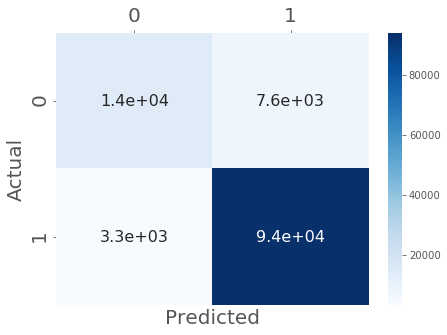

In [38]:
# confusion matrix for mi_lr
conf_mat_plot(y_test, y_pred)

Modelo parece decente, pero hay espacio para mejorarlo.

In [39]:
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72     21979
           1       0.92      0.97      0.94     97286

    accuracy                           0.91    119265
   macro avg       0.87      0.81      0.83    119265
weighted avg       0.90      0.91      0.90    119265

